In [234]:
import os
import matplotlib.pyplot as plt
import re
import sys
import numpy as np
from scipy.stats import norm
import scipy.integrate as integrate
import math 
import pandas as pd
font_size=15
lw=4
line_w=lw

myblue = (0,119/235,187/235)
myred=(187/235,85/235,102/235)
myyellow=(221/235,170/235,51/235)
mygrey=(187/235,187/235,187/235)
mygreen="#66BB55"
mymagenta="#7733DD"
myblack="#48494B"
import matplotlib.ticker as mtick
plt.rc('xtick', labelsize=font_size) 
plt.rc('ytick', labelsize=font_size) 

path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/underdamped/validate/fewtraj"

def openCfile(file):
    """
    Open the C txt file in order to obtain m_1 matrix of results 
    -----------
    Input
    -----------
    file: txt file
        m_1 file containing the results from the C simulation

    Return
    -----------
    mat: list of list
        m_1 matrix containing the results of the simulations 
    """
    with open(file) as f:
        cols = f.readlines() #columns in the txt file
    n_col = len(cols) #number of columns in the text file
    mat=[] # matrix 
    for i in range(n_col): # for each columns 
        elems_i=cols[i].split(" ") #split the elements using " "
        col_i=[] #create an empty column i 
        for elem in elems_i: #for each element of the list 
            if elem!="\n" and elem!=" ": #compare each elements and discard " " and "\n"
                col_i.append(float(elem)) #append elems that are floats to the vector of interest
        mat.append(col_i) #create the matrix
    mat=np.array(mat)
    return(mat) #return the value of the matrix.


In [63]:
#######################################################
##### read file from c code
#######################################################
def openCfile_qp(file):
    with open(file) as f:
        cols = f.readlines() #columns in the txt file
    n_col = len(cols) #number of columns in the text file
    # when fill_p is 1, then fill in the matrix q
    fill_p=0
    fill_g=0
    # vector of res
    vals_q=[] #create an empty column i 
    vals_p=[] #create an empty column i
    vals_g=[] #create an empty column i  
    for i in range(n_col): # for each columns 
        if cols[i]=='q\n':
            fill_q=1
            i+=1
        if cols[i]=='p\n':
            fill_p=1
            fill_q=0
            i+=1
        if cols[i]=='g\n':
            fill_g=1
            fill_q=0
            fill_p=0
            i+=1
        # clean up the cols 
        elems_i=cols[i].split(" ") #split the elements using " "
        for elem in elems_i: #for each element of the list 
            if elem!="\n" and elem!=" ": #compare each elements and discard " " and "\n"
                if fill_q==1:
                    vals_q.append(float(elem)) #append elems that are floats to the vector of interest
                elif fill_p==1:
                    vals_p.append(float(elem))
                elif fill_g==1:
                    vals_g.append(float(elem))
    return np.array(vals_q),np.array(vals_p),np.array(vals_g)


## Validate the underdamped code with a simple potential

Say we generate data $x_i \sim N(\mu,1)$ with $\mu = \frac{1}{2}$ and $i=1, \dots,N$.

The likelihood in this bayesian setting is set as:
$$
l(x_i|\mu) \propto \exp \left( -\frac{\|x_i-\mu\|^2}{2} \right) \\
\rightarrow l(\bold{x}|\mu) \propto \prod_i^N \exp \left(- \frac{\|x_i-\mu\|^2}{2} \right)
$$

and the prior is: 
$$
\pi(\mu) \propto \exp \left( -\left(\mu-a\right)^{2K}\right) 
$$
with $K=2,7,15$.


The potential becomes: 
$$
V(\mu) = \log p(\mu|\bold{x}) \\
V(\mu) = \sum_i^N -\frac{1}{2} \|x_i-\mu\|^2 - \left(\mu-a\right)^{2K} + Cst
$$

<!-- And the force: 
$$
- F(\kappa) = \nabla V(\kappa) \\
- F(\kappa) = - \frac{N-1}{(\kappa-1)(\kappa)} + \frac{\kappa \sum \|x_i\|^2}{(\kappa-1)^3} - \frac{1}{2} \left(\frac{1}{\kappa-a} + \frac{1}{\kappa-b} \right)
$$ -->

2


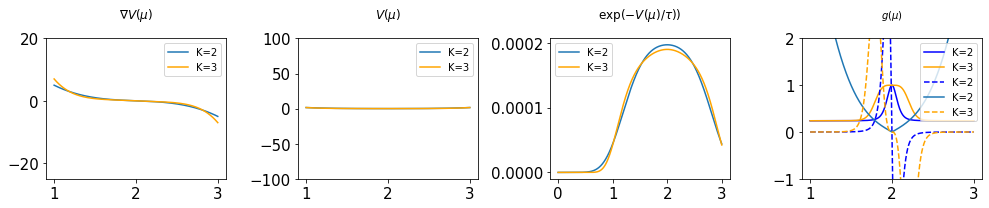

In [235]:
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(20,3))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.25,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
font_size=10
K1=2
K2=3
a=2
m1=0.1
M1=1/1
r=10
tau=1

np.random.seed(14)
N=1
X = 2
sumX=np.sum(X)
print(sumX)
def U(x,K):
    res=0
    #for xi in X:
    res+=-(X-x)**2/2
    res+=-(x-a)**(2*K)
    return -res

def Up(x,K):
    res=sumX-N*x-2*K*(x-a)**(2*K-1)
    return res

def invariant(x,K):
    res = np.exp(-U(x,K)/tau)
    return res

def getg(x,K):
    f=pow(x-a,2*K-2)*2*K*(2*K-1)*r
    f2=f*f;
    xi=np.sqrt(1+m1*f2);
    den=M1*xi+np.sqrt(f2);
    g=xi/den;
    return g

def getgprime(x,K):
    f=pow(x-a,2*K-2)*2*K*(2*K-1)*r
    f2=f*f;
    fp=pow(x-sumX/N,2*K-3)*2*K*(2*K-1)*(2*K-3)*r
    xi=np.sqrt(1+m1*f2);
    sqf=np.sqrt(f2);
    gp=-f*fp/(sqf*xi*pow(M1*xi+sqf,2));
    return(gp)

    
mu = np.linspace(1.,3,10000)

K=K1
ax1.plot(mu,Up(mu,K1),label="K="+str(K1))
ax1.plot(mu,Up(mu,K2),label="K="+str(K2),color="orange")
ax1.set_title("$\\nabla V(\mu)$",y=1.1)
ax1.legend()
ax1.set_ylim([-25,20])

# ax1.set_yscale("log")
ax2.plot(mu,U(mu,K1),label="K="+str(K1))
ax2.plot(mu,U(mu,K2),label="K="+str(K2),color="orange")
ax2.set_title("$ V(\mu)$",y=1.1)
ax2.set_ylim([-100,100])
ax2.legend()

mu = np.linspace(0.,3,10000)
ax3.plot(mu,invariant(mu,K1)/np.sum(invariant(mu,K1)),label="K="+str(K1))
ax3.plot(mu,invariant(mu,K2)/np.sum(invariant(mu,K2)),label="K="+str(K2),color="orange")
ax3.set_title("$ \\exp(-V(\mu)/\\tau))$",y=1.1)
# ax3.set_ylim([-100,100])
ax3.legend()

mu = np.linspace(1.,3,10000)
ax4.plot(mu,getg(mu,K1),label="K="+str(K1),color="blue")
ax4.plot(mu,getg(mu,K2),label="K="+str(K2),color="orange")

ax4.plot(mu,getgprime(mu,K1),"--",label="K="+str(K1),color="blue")
ax4.plot(mu,np.abs(Up(mu,K1)),label="K="+str(K1))

ax4.plot(mu,getgprime(mu,K2),"--",label="K="+str(K2),color="orange")
ax4.set_title("$ g(\mu)$",y=1.1,fontsize=font_size)
ax4.set_ylim([-1,2])
ax4.legend(fontsize=font_size)

# ax4.plot(mu,U(mu,K1),label="K="+str(K1))
# ax4.plot(mu,U(mu,K2),label="K="+str(K2),color="black")

## Plot moments

In [232]:
np.round(np.linspace(0.25,0.05,10),4)

array([0.25  , 0.2278, 0.2056, 0.1833, 0.1611, 0.1389, 0.1167, 0.0944,
       0.0722, 0.05  ])

In [237]:
## When no access to the true moment
# POTENTIAL 
Kused=4
m1=0.9
M1=1/1.
tau=1
def getU(x):
    res = U(x,Kused)
    return res

## RANGE

range_int=[-10,10]
r0=range_int[0]
r1=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-getU(q)/tau), r0,r1)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-getU(q)/tau)*(q), r0,r1)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-getU(q)/tau)*q*q, r0,r1)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-getU(q)/tau)*(q)**3, r0,r1)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-getU(q)/tau)*q*q*q*q, r0,r1)[0],16)/norm
print(true_mom_1)
print(true_mom_2)
print(true_mom_3)
print(true_mom_4)

2.0
4.272277132984518
9.633662797907114
22.686935112896876


[           nan            nan            nan            nan
            nan            nan            nan            nan
 6.07562843e-05 4.20304022e-03]
[       nan        nan        nan 0.01509433 0.03625308 0.02391249
 0.02913336 0.00204766 0.02758541 0.04197862]
[       nan        nan        nan        nan 0.06337857 0.23515297
 0.04247056 0.00317713 0.00780003 0.07882276]


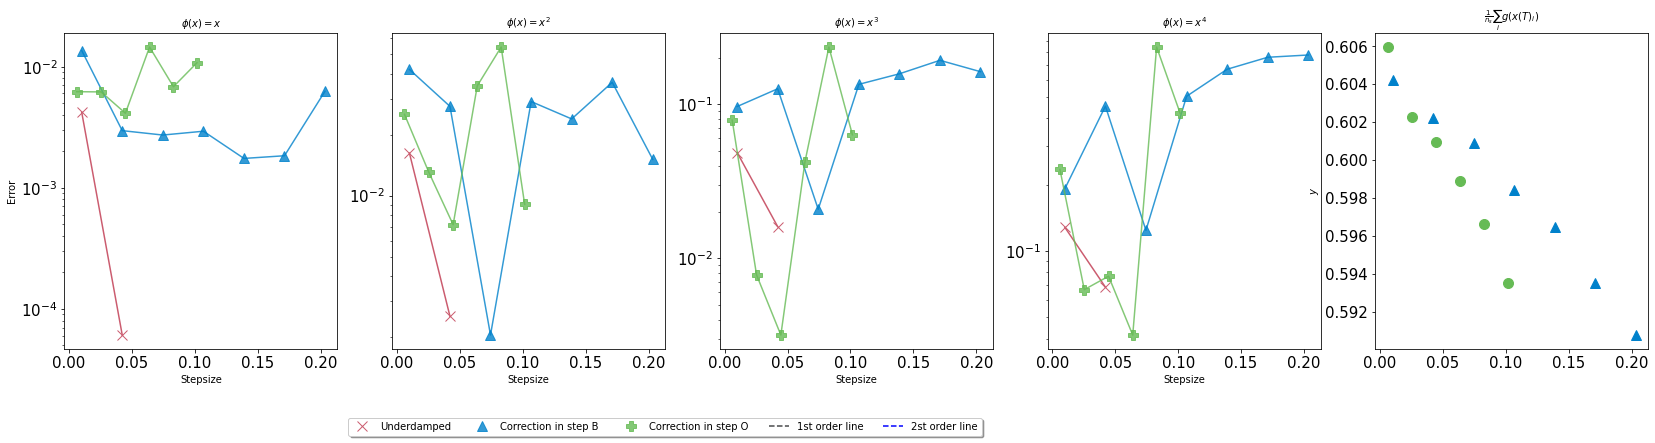

In [238]:
# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/underdamped/bayesian/"

mksize=10

dtlist=np.round(np.linspace(0.3,0.01,10),4)

gvalsB=np.hstack(openCfile(path1+"vec_g_B.txt"))

# ###########################################
# ## Adjust the step size to have an estimation of the actual effort 
# ###########################################
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4,ax5)= plt.subplots(1,5,figsize=(40,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.25,bottom=0.25, right=0.8, top=0.8, wspace=0.2, hspace=0.4)
# fig.suptitle("Underdamped with spring potential with burn in=5000, Nt=60 000 (every 100 value) and Ns 107 independantes trajectories",fontsize=font_size)
## no adaptive 
###############
lab="Underdamped"

# Upload moments
mom1_list=np.hstack(openCfile(path1+"noada_moment1.txt"))
mom2_list=np.hstack(openCfile(path1+"noada_moment2.txt"))
mom3_list=np.hstack(openCfile(path1+"noada_moment3.txt"))
mom4_list=np.hstack(openCfile(path1+"noada_moment4.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
mom4_list=np.abs(mom4_list-true_mom_4)

# Set the actual step size used

xnoada=xm
#Plot moments
ax1.semilogy(xnoada,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xnoada,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xnoada,(mom3_list),"x",markersize=mksize,color=myred,label=lab)
ax4.semilogy(xnoada,(mom4_list),"x",markersize=mksize,color=myred,label=lab)

ax1.semilogy(xnoada,(mom1_list),color=myred)
ax2.semilogy(xnoada,(mom2_list),color=myred)
ax3.semilogy(xnoada,(mom3_list),color=myred)
ax4.semilogy(xnoada,(mom4_list),color=myred)

# # ## Add the first order line 
# lb=0
# ub=len(dtlist) #len(dtlist)+1
# x = (dtlist[lb:ub])
# A = np.vstack([x, np.ones(len(x))]).T
# m, c = np.linalg.lstsq(A, np.log10((mom1_list)[lb:ub]), rcond=None)[0]
# # ax1.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
# ax1.semilogy(dtlist[lb:ub], 10**(2*x + c-0.2),"--",color="blue")
# # ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)
print(mom1_list)
## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B "
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list=np.hstack(openCfile(path1+"tr_moment1B.txt"))
mom2_list=np.hstack(openCfile(path1+"tr_moment2B.txt"))
mom3_list=np.hstack(openCfile(path1+"tr_moment3B.txt"))
mom4_list=np.hstack(openCfile(path1+"tr_moment4B.txt"))

gvals=np.hstack(openCfile(path1+"vec_g_B.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,alpha=0.8,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,alpha=0.8,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,alpha=0.8,label=lab)
ax4.semilogy(xm,(mom4_list),"^",markersize=mksize,color=myblue,alpha=0.8,label=lab)

ax1.semilogy(xm,(mom1_list),color=myblue,alpha=0.8)
ax2.semilogy(xm,(mom2_list),color=myblue,alpha=0.8)
ax3.semilogy(xm,(mom3_list),color=myblue,alpha=0.8)
ax4.semilogy(xm,(mom4_list),color=myblue,alpha=0.8)

ax5.plot(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)

# ## Add the first order line 
lb=0
ub=len(dtlist) #len(dtlist)+1
x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom1_list)[lb:ub]), rcond=None)[0]
# ax1.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
ax1.semilogy(dtlist[lb:ub], 10**(2*x + c-0.2),"--",color="blue")
# ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom2_list)[lb:ub]), rcond=None)[0]
# ax2.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
ax2.semilogy(dtlist[lb:ub], 10**(2*x + c),"--",color="blue",label="2st order line")

print(mom2_list)

## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O"
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

## adjust to the average size used in O 
gvalsB=np.hstack(openCfile(path1+"vec_g_O.txt"))
xm=dtlist*gvalsB

# Upload moments
mom1_list=np.hstack(openCfile(path1+"tr_moment1O.txt"))
mom2_list=np.hstack(openCfile(path1+"tr_moment2O.txt"))
mom3_list=np.hstack(openCfile(path1+"tr_moment3O.txt"))
mom4_list=np.hstack(openCfile(path1+"tr_moment4O.txt"))

gvals=np.hstack(openCfile(path1+"vec_g_O.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"P",markersize=mksize,color=mygreen,alpha=0.8,label=lab)
ax2.semilogy(xm,(mom2_list),"P",markersize=mksize,color=mygreen,alpha=0.8,label=lab)
ax3.semilogy(xm,(mom3_list),"P",markersize=mksize,color=mygreen,alpha=0.8,label=lab)
ax4.semilogy(xm,(mom4_list),"P",markersize=mksize,color=mygreen,alpha=0.8,label=lab)

ax1.semilogy(xm,(mom1_list),color=mygreen,alpha=0.8)
ax2.semilogy(xm,(mom2_list),color=mygreen,alpha=0.8)
ax3.semilogy(xm,(mom3_list),color=mygreen,alpha=0.8)
ax4.semilogy(xm,(mom4_list),color=mygreen,alpha=0.8)
ax5.plot(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

print(mom3_list)
# ## Add the first order line 
lb=0
ub=len(dtlist) #len(dtlist)+1
x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom1_list)[lb:ub]), rcond=None)[0]
ax1.semilogy(dtlist[lb:ub], 10**(1*x + c-0.1),"--",color=myblack,label="1st order line")
ax1.semilogy(dtlist[lb:ub], 10**(2*x + c-0.1),"--",color="blue",label="2st order line")
# ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom2_list)[lb:ub]), rcond=None)[0]
ax2.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
ax2.semilogy(dtlist[lb:ub], 10**(2*x + c),"--",color="blue",label="2st order line")
# ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom3_list)[lb:ub]), rcond=None)[0]
ax3.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
ax3.semilogy(dtlist[lb:ub], 10**(2*x + c),"--",color="blue",label="2st order line")
# ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)


x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom4_list)[lb:ub]), rcond=None)[0]
ax4.semilogy(dtlist[lb:ub], 10**(1*x + c),"--",color=myblack,label="1st order line")
ax4.semilogy(dtlist[lb:ub], 10**(2*x + c),"--",color="blue",label="2st order line")
# ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)

# ax1.set_ylim([10**(-2),10**1]) #change to -7.5 for a=2.5
# ax2.set_ylim([10**(-1),10**4]) #change to -7.5 for a=2.5
# ax3.set_ylim([10**(-0),10**6]) #change to -7.5 for a=2.5
# # ax4.set_ylim([10**(1),10**8]) #change to -7.5 for a=2.5
# ax1.set_xlim(0.1,0.25)
# ax2.set_xlim(0.1,0.25)
# ax3.set_xlim(0.1,0.25)
# ax4.set_xlim(0.1,0.25)

#label of ]y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\phi(x)=x^4$",fontsize=font_size)

ax5.set_title("$\\frac{1}{n_s}\\sum_{i} g(x(T)_i)$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
ax5.set_ylabel("$y$",fontsize=font_size)

# label of x axis
ax1.set_xlabel("Stepsize",fontsize=font_size)
ax2.set_xlabel("Stepsize",fontsize=font_size)
ax3.set_xlabel("Stepsize",fontsize=font_size)
ax4.set_xlabel("Stepsize",fontsize=font_size)

ax1.legend(loc='upper center', bbox_to_anchor=(2.2, -0.2),fontsize=font_size,
          fancybox=True, shadow=True, ncol=5)


## Check the final distributions

/home/s2133976/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


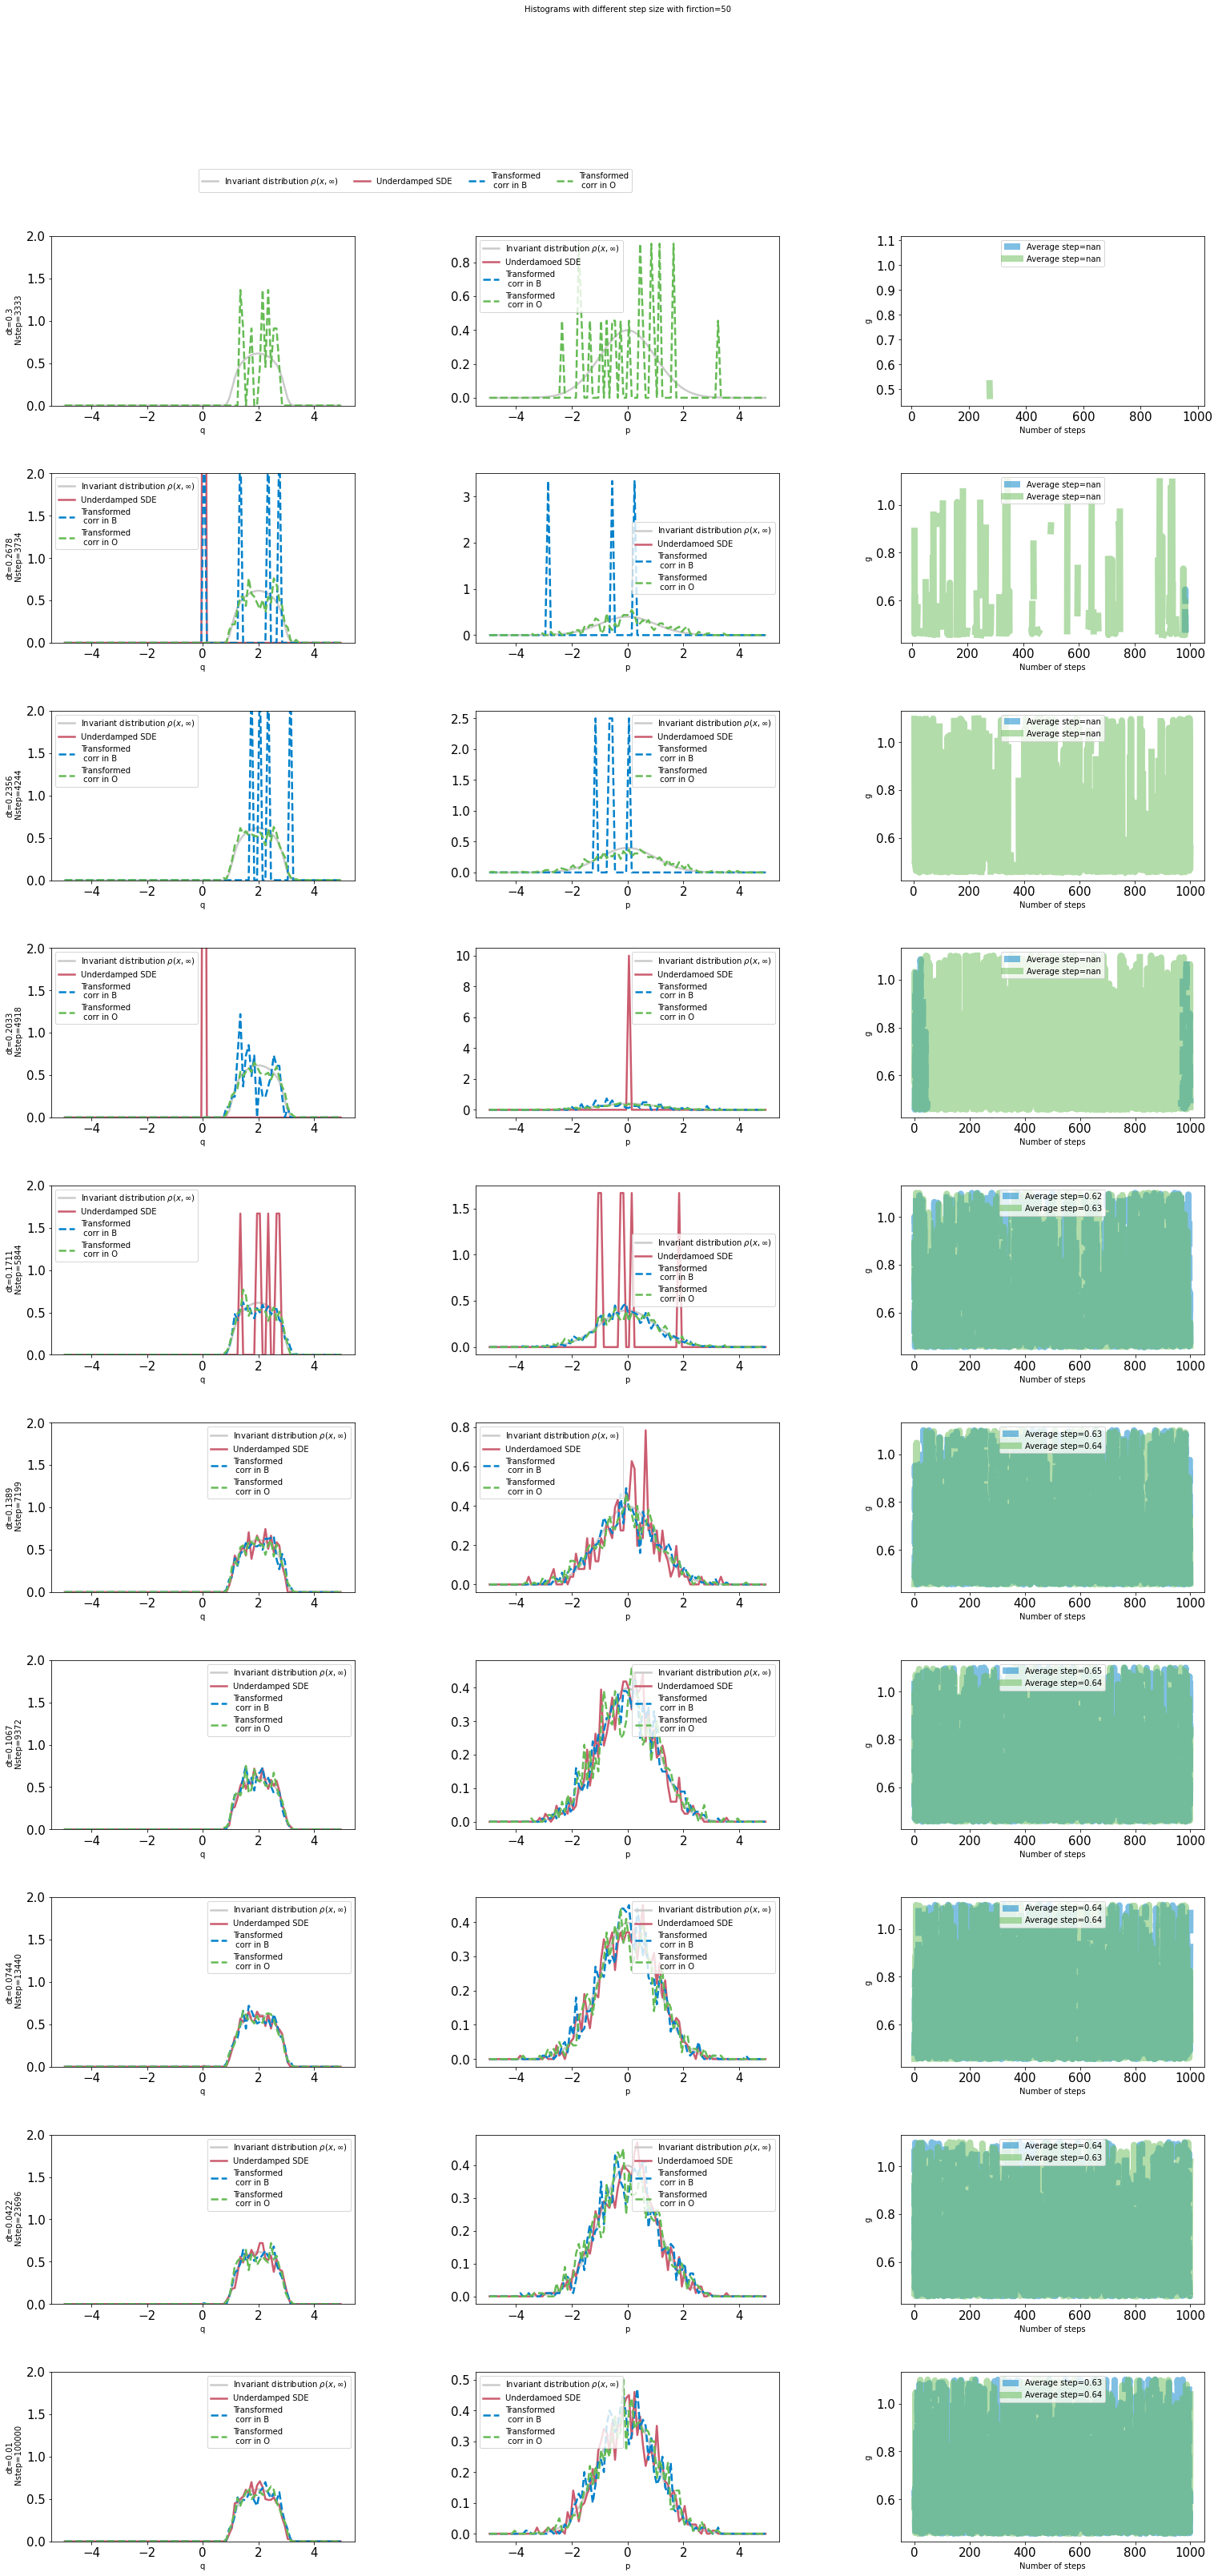

In [250]:
numsam=len(dtlist)
path=path1
M1=0.5
fig, ((axs))= plt.subplots(numsam,3,figsize=(25,50))# plt.figure(figsize=(4,4))
fig.suptitle("Histograms with different step size with firction=50",fontsize=font_size)
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
nbins=250
rg=5
range_bins=[-rg,rg]
tau=1
T=1000
for i in range(numsam):
    filename= path+"vec_noada_qi="+str(i)+".txt"
    q_noada=np.hstack(openCfile(filename))
    filename= path+"vec_noada_pi="+str(i)+".txt"
    p_noada=np.hstack(openCfile(filename))

    # Correction step in O
    filename= path+"vec_tr_O_qi="+str(i)+".txt"
    q_tr_O=np.hstack(openCfile(filename))
    filename= path+"vec_tr_O_pi="+str(i)+".txt"
    p_tr_O=np.hstack(openCfile(filename))
    filename= path+"vec_tr_O_gi="+str(i)+".txt"
    g_O=np.hstack(openCfile(filename))

    # Correction step in B 
    filename= path+"vec_tr_B_qi="+str(i)+".txt"
    q_tr_B=np.hstack(openCfile(filename))
    filename= path+"vec_tr_B_pi="+str(i)+".txt"
    p_tr_B=np.hstack(openCfile(filename))
    filename= path+"vec_tr_B_gi="+str(i)+".txt"
    g_B=np.hstack(openCfile(filename))


    t=np.linspace(0,len(q_noada),len(q_noada))


    nbins=100
    ############
    ## Q vals ## 
    ############
    # SDE
    histogram_sde,bins = np.histogram(q_noada,bins=nbins,range=range_bins, density=True)
    midx_sde = (bins[0:-1]+bins[1:])/2

    # transformed - correction in B
    histogram_tr_B,bins = np.histogram(q_tr_B,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    # transformed - correction in O
    histogram_tr_O,bins = np.histogram(q_tr_O,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    #Invariant distribution
    rho = np.exp(- getU(midx_sde)/tau)
    rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

    axs[i,0].plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
    axs[i,0].plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamped SDE',color=myred)
    axs[i,0].plot(midx_tr,histogram_tr_B,"--",linewidth=2.5,label='Transformed\n corr in B',color=myblue)
    axs[i,0].plot(midx_tr,histogram_tr_O,"--",linewidth=2.5,label='Transformed\n corr in O',color=mygreen)
    axs[i,0].legend()
    axs[i,0].set_xlabel("q",fontsize=font_size)
    axs[i,0].set_ylabel("dt="+str(dtlist[i])+"\n Nstep="+str(int(T/dtlist[i])),fontsize=font_size)
    axs[i,0].set_ylim(0,2)
    ############
    ## P vals ## 
    ############

        # SDE
    histogram_sde,bins = np.histogram(p_noada,bins=nbins,range=range_bins, density=True)
    midx_sde = (bins[0:-1]+bins[1:])/2

    # transformed - B
    histogram_tr_B,bins = np.histogram(p_tr_B,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    # transformed - O
    histogram_tr_O,bins = np.histogram(p_tr_O,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    # Invariant distribution
    rho = np.exp(- midx_sde*midx_sde/(2*tau))
    rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

    axs[i,1].plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
    axs[i,1].plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamoed SDE',color=myred)
    axs[i,1].plot(midx_tr,histogram_tr_B,"--",linewidth=2.5,label='Transformed\n corr in B',color=myblue)
    axs[i,1].plot(midx_tr,histogram_tr_O,"--",linewidth=2.5,label='Transformed\n corr in O',color=mygreen)
    axs[i,1].legend()
    axs[i,1].set_xlabel("p",fontsize=font_size)



    # axs[i,1].plot(t,p_noada,"-",linewidth=lw,label='Underdamped SDE',color=myred)
    # axs[i,1].plot(t,p_tr,"--",linewidth=lw,alpha=0.7,label='Transformed\nunderdamped SDE',color=myblue)
    # axs[i,1].set_ylabel("p", fontsize=font_size)
    # axs[i,1].set_xlabel("Number of steps", fontsize=font_size)

    ############
    ## Histograms g vals ## 
    ############
    range_bins_g=[0,M1+0.1]
    midx_noada = (bins[0:-1]+bins[1:])/2

    # Underdamped: corr in B
    histogram_g_B,bins = np.histogram(g_B,bins=nbins,range=range_bins_g, density=True)
    mean_g_B=round(np.mean(g_B),2)

    # Underdamped: corr in O
    histogram_g_O,bins = np.histogram(g_O,bins=nbins,range=range_bins_g, density=True)
    mean_g_O=round(np.mean(g_O),2)

    axs[i,2].plot(t,g_B,"--",linewidth=lw*2,alpha=0.5,label='Average step='+str(mean_g_B),color=myblue)
    axs[i,2].plot(t,g_O,linewidth=lw*2,alpha=0.5,label='Average step='+str(mean_g_O),color=mygreen)
    axs[i,2].legend(fontsize=font_size, loc="upper center")
    axs[i,2].set_ylabel("g", fontsize=font_size)
    axs[i,2].set_xlabel("Number of steps", fontsize=font_size)

axs[0,0].legend(fontsize=font_size,loc="upper center",ncol=4,bbox_to_anchor=(1.2, 1.42))

## Plot the escaping trajectories

In [258]:
xm=np.round(np.linspace(0.25,0.15,20),4)
xm

array([0.25  , 0.2447, 0.2395, 0.2342, 0.2289, 0.2237, 0.2184, 0.2132,
       0.2079, 0.2026, 0.1974, 0.1921, 0.1868, 0.1816, 0.1763, 0.1711,
       0.1658, 0.1605, 0.1553, 0.15  ])

[0.25   0.2389 0.2278 0.2167 0.2056 0.1944 0.1833 0.1722 0.1611 0.15  ]
[935. 861. 732. 512. 330. 160.  72.  20.   5.   2.]
[932. 725. 818.   0.   0.   0.   0.   0.   0.   0.]
[43. 26.  4.  0.  0.  0.  0.  0.  0.  0.]


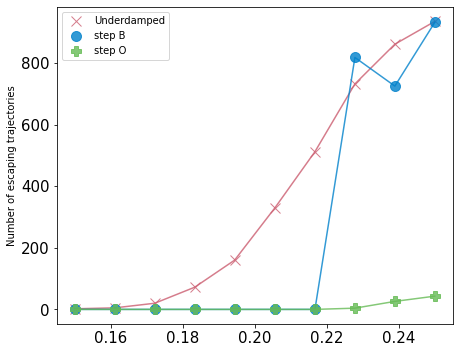

In [257]:

# ###########################################
# ## Adjust the step size to have an estimation of the actual effort 
# ###########################################
xm=np.round(np.linspace(0.25,0.15,20),4)
print(xm)
# ###########################################
# ## Compute the number of escaping traj
# ###########################################
fig, (ax1)= plt.subplots(1,1,figsize=(10,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.25,bottom=0.25, right=0.8, top=0.8, wspace=0.2, hspace=0.4)
# fig.suptitle("Underdamped with spring potential with burn in=5000, Nt=60 000 (every 100 value) and Ns 107 independantes trajectories",fontsize=font_size)
## no adaptive 
###############
lab="Underdamped"

# Upload moments
noada=np.hstack(openCfile(path1+"noada_nescaping.txt"))/5000
methB=np.hstack(openCfile(path1+"tr_B_nescaping.txt"))/5000
methO=np.hstack(openCfile(path1+"tr_O_nescaping.txt"))/5000

print(noada)
print(methB)
print(methO)

lab="Underdamped"
xm_noada=xm
ax1.plot(xm,(noada),"x",markersize=mksize,color=myred,alpha=0.8,label=lab)
ax1.plot(xm,(noada),color=myred,alpha=0.8)

ax1.plot(xm,(methB),"o",markersize=mksize,color=myblue,alpha=0.8,label="step B")
ax1.plot(xm,(methB),color=myblue,alpha=0.8)

ax1.plot(xm,(methO),"P",markersize=mksize,color=mygreen,alpha=0.8,label="step O")
ax1.plot(xm,(methO),color=mygreen,alpha=0.8)

ax1.set_xlabel("dt", fontsize=font_size)
ax1.set_ylabel("Number of escaping trajectories", fontsize=font_size)

ax1.legend()

0.4444444479751914

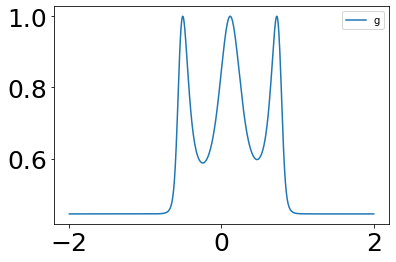

In [98]:
r=100
d=5
M1=1/1
m1=0.8**2


def getg(x):
    f=r*pow((x-0.1142)*(x+0.5088)*(x-0.7270),2);
    f2=f*f;
    xi=np.sqrt(1+m1*f2);
    den=M1*xi+np.sqrt(f2);
    g=xi/den;

    return(g);

def getgprime(x):
    f=r*pow((x-0.1142)*(x+0.5088)*(x-0.7270),2);
    f2=f*f;
    fp=60*(-0.00485757+0.0303093*x + 0.156913*x*x-0.386312*pow(x,3)-0.554*pow(x,4)+pow(x,5));
    xi=np.sqrt(1+m1*f2);
    sqf=f/np.sqrt(f2);
    gp=-f*fp/(sqf*xi*pow(M1*xi+sqf,2));
    return(gp);

xplot=np.linspace(-2,2,1000)
plt.plot(xplot,getg(xplot),label="g")
# plt.plot(xplot,getgprime(xplot),label="gprime")
plt.legend()
np.min(getg(xplot))

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

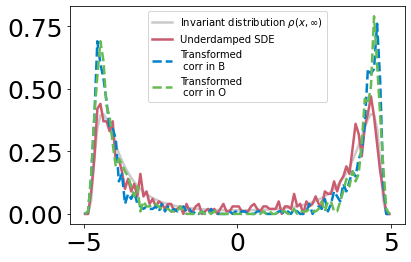

In [14]:
i=0
filename= path+"vec_noada_qi="+str(i)+".txt"
q_noada=np.hstack(openCfile(filename))
filename= path+"vec_noada_pi="+str(i)+".txt"
p_noada=np.hstack(openCfile(filename))

# Correction step in O
filename= path+"vec_tr_O_qi="+str(i)+".txt"
q_tr_O=np.hstack(openCfile(filename))
filename= path+"vec_tr_O_pi="+str(i)+".txt"
p_tr_O=np.hstack(openCfile(filename))
filename= path+"vec_tr_O_gi="+str(i)+".txt"
g_O=np.hstack(openCfile(filename))

# Correction step in B 
filename= path+"vec_tr_B_qi="+str(i)+".txt"
q_tr_B=np.hstack(openCfile(filename))
filename= path+"vec_tr_B_pi="+str(i)+".txt"
p_tr_B=np.hstack(openCfile(filename))
filename= path+"vec_tr_B_gi="+str(i)+".txt"
g_B=np.hstack(openCfile(filename))


t=np.linspace(0,len(q_noada),len(q_noada))


nbins=100
############
## Q vals ## 
############
# SDE
histogram_sde,bins = np.histogram(q_noada,bins=nbins,range=range_bins, density=True)
midx_sde = (bins[0:-1]+bins[1:])/2

# transformed - correction in B
histogram_tr_B,bins = np.histogram(q_tr_B,bins=nbins,range=range_bins, density=True)
midx_tr = (bins[0:-1]+bins[1:])/2

# transformed - correction in O
histogram_tr_O,bins = np.histogram(q_tr_O,bins=nbins,range=range_bins, density=True)
midx_tr = (bins[0:-1]+bins[1:])/2
tau=5
def U(x):
    return (-x*x+1/(np.abs(x)-5)**2)
#Invariant distribution
rho = np.exp(- U(midx_sde)/tau)
rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

plt.plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
plt.plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamped SDE',color=myred)
plt.plot(midx_tr,histogram_tr_B,"--",linewidth=2.5,label='Transformed\n corr in B',color=myblue)
plt.plot(midx_tr,histogram_tr_O,"--",linewidth=2.5,label='Transformed\n corr in O',color=mygreen)
plt.legend()
plt.set_xlabel("q",fontsize=font_size)
plt.set_ylabel("dt="+str(dtlist[i])+"\n Nstep="+str(int(T/dtlist[i])),fontsize=font_size)

############
## P vals ## 
############

#     # SDE
# histogram_sde,bins = np.histogram(p_noada,bins=nbins,range=range_bins, density=True)
# midx_sde = (bins[0:-1]+bins[1:])/2

# # transformed - B
# histogram_tr_B,bins = np.histogram(p_tr_B,bins=nbins,range=range_bins, density=True)
# midx_tr = (bins[0:-1]+bins[1:])/2

# # transformed - O
# histogram_tr_O,bins = np.histogram(p_tr_O,bins=nbins,range=range_bins, density=True)
# midx_tr = (bins[0:-1]+bins[1:])/2

# # Invariant distribution
# rho = np.exp(- midx_sde*midx_sde/tau)
# rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

# axs[i,1].plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
# axs[i,1].plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamoed SDE',color=myred)
# axs[i,1].plot(midx_tr,histogram_tr_B,"--",linewidth=2.5,label='Transformed\n corr in B',color=myblue)
# axs[i,1].plot(midx_tr,histogram_tr_O,"--",linewidth=2.5,label='Transformed\n corr in O',color=mygreen)
# axs[i,1].legend()
# axs[i,1].set_xlabel("p",fontsize=font_size)



# # axs[i,1].plot(t,p_noada,"-",linewidth=lw,label='Underdamped SDE',color=myred)
# # axs[i,1].plot(t,p_tr,"--",linewidth=lw,alpha=0.7,label='Transformed\nunderdamped SDE',color=myblue)
# # axs[i,1].set_ylabel("p", fontsize=font_size)
# # axs[i,1].set_xlabel("Number of steps", fontsize=font_size)

# ############
# ## Histograms g vals ## 
# ############
# range_bins_g=[0,M1+0.1]
# midx_noada = (bins[0:-1]+bins[1:])/2

# # Underdamped: corr in B
# histogram_g_B,bins = np.histogram(g_B,bins=nbins,range=range_bins_g, density=True)
# mean_g_B=round(np.mean(g_B),2)

# # Underdamped: corr in O
# histogram_g_O,bins = np.histogram(g_O,bins=nbins,range=range_bins_g, density=True)
# mean_g_O=round(np.mean(g_O),2)

# axs[i,2].plot(t,g_B,"--",linewidth=lw*2,alpha=0.5,label='Average step='+str(mean_g_B),color=myblue)
# axs[i,2].plot(t,g_O,linewidth=lw*2,alpha=0.5,label='Average step='+str(mean_g_O),color=mygreen)
# axs[i,2].legend(fontsize=font_size, loc="upper center")
# axs[i,2].set_ylabel("g", fontsize=font_size)
# axs[i,2].set_xlabel("Number of steps", fontsize=font_size)


### Try different strategies for the spring potential to confirm the results 


In [20]:

## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################
a=  15
b=  0.1
x0= 0.5
c=  0.1
tau=1

# dtlist = np.array([np.exp(-3.93),np.exp(-3.36),np.exp(-2.79),np.exp(-2.21),np.exp(-1.64),np.exp(-1.07),np.exp(-0.5)])
def U(x):
    res = (a**1.5*b**0.5*x0*np.arctan((a/b)**0.5*(x-x0))+(a*b*(a*x0*(x-x0)-b))/(a*(x-x0)**2+b)+c*(x-x0)**2+2*c*(x-x0)*x0)*0.5
    return res

range_int=[-10,10]
r0=range_int[0]
r1=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), r0,r1)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q), r0,r1)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, r0,r1)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, r0,r1)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, r0,r1)[0],16)/norm

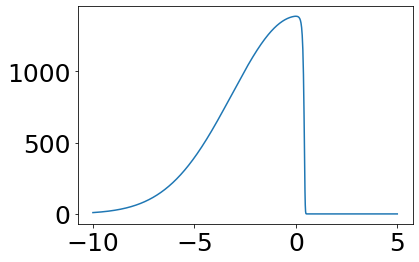

In [372]:
xlist=np.linspace(-10,5,1000)
plt.plot(xlist,np.exp(-U(xlist)/tau))

In [373]:
dtlist=np.round(np.linspace(0.05,.7,10),4)
dtlist

array([0.05  , 0.1222, 0.1944, 0.2667, 0.3389, 0.4111, 0.4833, 0.5556,
       0.6278, 0.7   ])

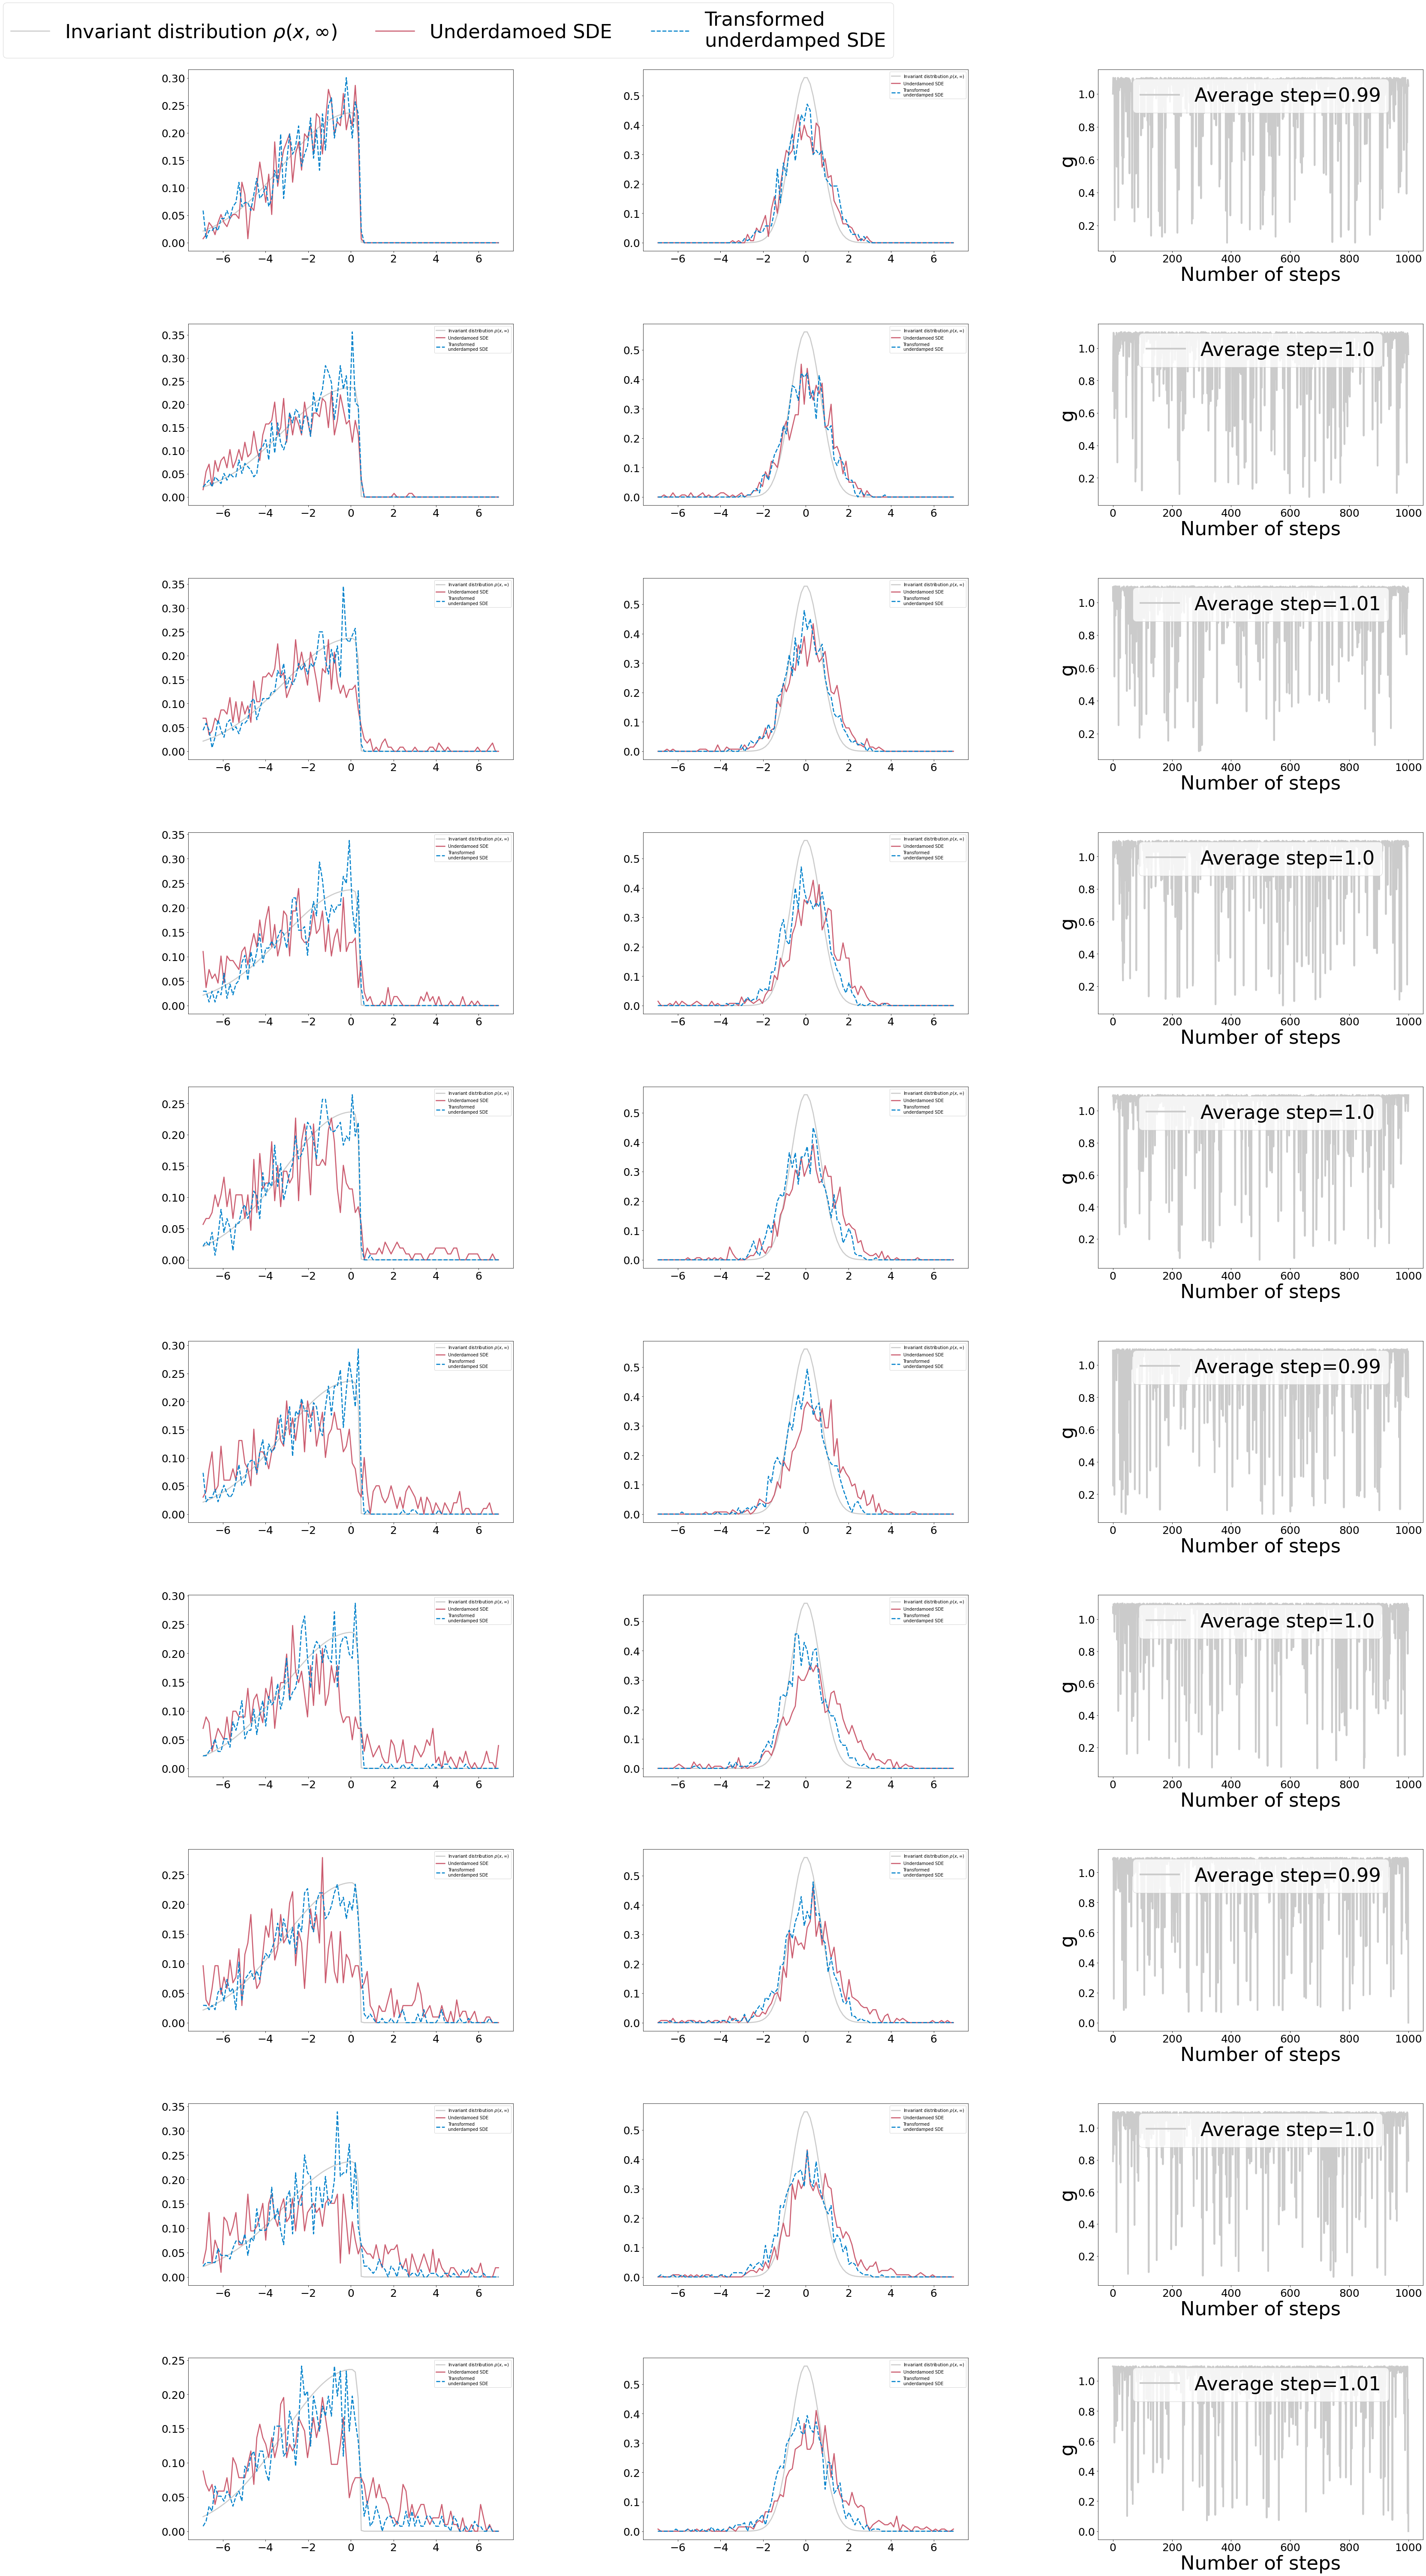

In [374]:
path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/underdamped/spring_validate/v2/"
numsam=10
fig, ((axs))= plt.subplots(numsam,3,figsize=(50,100))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
nbins=250
rg=7
range_bins=[-rg,rg]
font_size=45
for i in range(numsam):
    filename= path+"vec_noada_qi="+str(i)+".txt"
    q_noada=np.hstack(openCfile(filename))
    filename= path+"vec_noada_pi="+str(i)+".txt"
    p_noada=np.hstack(openCfile(filename))

    filename= path+"vec_tr_qi="+str(i)+".txt"
    q_tr=np.hstack(openCfile(filename))
    
    filename= path+"vec_tr_pi="+str(i)+".txt"
    p_tr=np.hstack(openCfile(filename))

    filename= path+"vec_tr_gi="+str(i)+".txt"
    g=np.hstack(openCfile(filename))

    t=np.linspace(0,len(q_noada),len(q_noada))


    nbins=100
    ############
    ## Q vals ## 
    ############
    # SDE
    histogram_sde,bins = np.histogram(q_noada,bins=nbins,range=range_bins, density=True)
    midx_sde = (bins[0:-1]+bins[1:])/2

    # transformed
    histogram_tr,bins = np.histogram(q_tr,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    # Invariant distribution
    rho = np.exp(- U(midx_sde)/tau)
    rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

    axs[i,0].plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
    axs[i,0].plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamoed SDE',color=myred)
    axs[i,0].plot(midx_tr,histogram_tr,"--",linewidth=2.5,label='Transformed\nunderdamped SDE',color=myblue)
    axs[i,0].legend()

    ############
    ## P vals ## 
    ############

        # SDE
    histogram_sde,bins = np.histogram(p_noada,bins=nbins,range=range_bins, density=True)
    midx_sde = (bins[0:-1]+bins[1:])/2

    # transformed
    histogram_tr,bins = np.histogram(p_tr,bins=nbins,range=range_bins, density=True)
    midx_tr = (bins[0:-1]+bins[1:])/2

    # Invariant distribution
    rho = np.exp(- midx_sde*midx_sde/tau)
    rho = rho / (np.sum(rho)* (midx_sde[1]-midx_sde[0]) ) # Normalize rho by dividing by its approx. integral

    axs[i,1].plot(midx_sde,rho,linewidth=2.5,label='Invariant distribution $\\rho(x,\\infty)$',color=mygrey)
    axs[i,1].plot(midx_sde,histogram_sde,"-",linewidth=2.5,label='Underdamoed SDE',color=myred)
    axs[i,1].plot(midx_tr,histogram_tr,"--",linewidth=2.5,label='Transformed\nunderdamped SDE',color=myblue)
    axs[i,1].legend()


    # axs[i,1].plot(t,p_noada,"-",linewidth=lw,label='Underdamped SDE',color=myred)
    # axs[i,1].plot(t,p_tr,"--",linewidth=lw,alpha=0.7,label='Transformed\nunderdamped SDE',color=myblue)
    # axs[i,1].set_ylabel("p", fontsize=font_size)
    # axs[i,1].set_xlabel("Number of steps", fontsize=font_size)

    ############
    ## Histograms g vals ## 
    ############
    range_bins_g=[0,M1+0.1]
    histogram_g,bins = np.histogram(g,bins=nbins,range=range_bins_g, density=True)
    midx_noada = (bins[0:-1]+bins[1:])/2
    mean_g=round(np.mean(g),2)

    axs[i,2].plot(t,g,linewidth=lw*2,label='Average step='+str(mean_g),color=mygrey)
    axs[i,2].legend(fontsize=font_size, loc="upper center")
    axs[i,2].set_ylabel("g", fontsize=font_size)
    axs[i,2].set_xlabel("Number of steps", fontsize=font_size)

axs[0,0].legend(fontsize=font_size,loc="upper center",ncol=3,bbox_to_anchor=(0.8, 1.42))

[0.47360553 0.55991583 0.5947146  0.60429929 0.63142106 0.58418108
 0.64416272 0.63676056 0.75378936 0.71235199]
[0.00660525 0.00941202 0.00352931 0.00514063 0.00798746 0.01038028
 0.00442533 0.00944427 0.00799292 0.00331557]


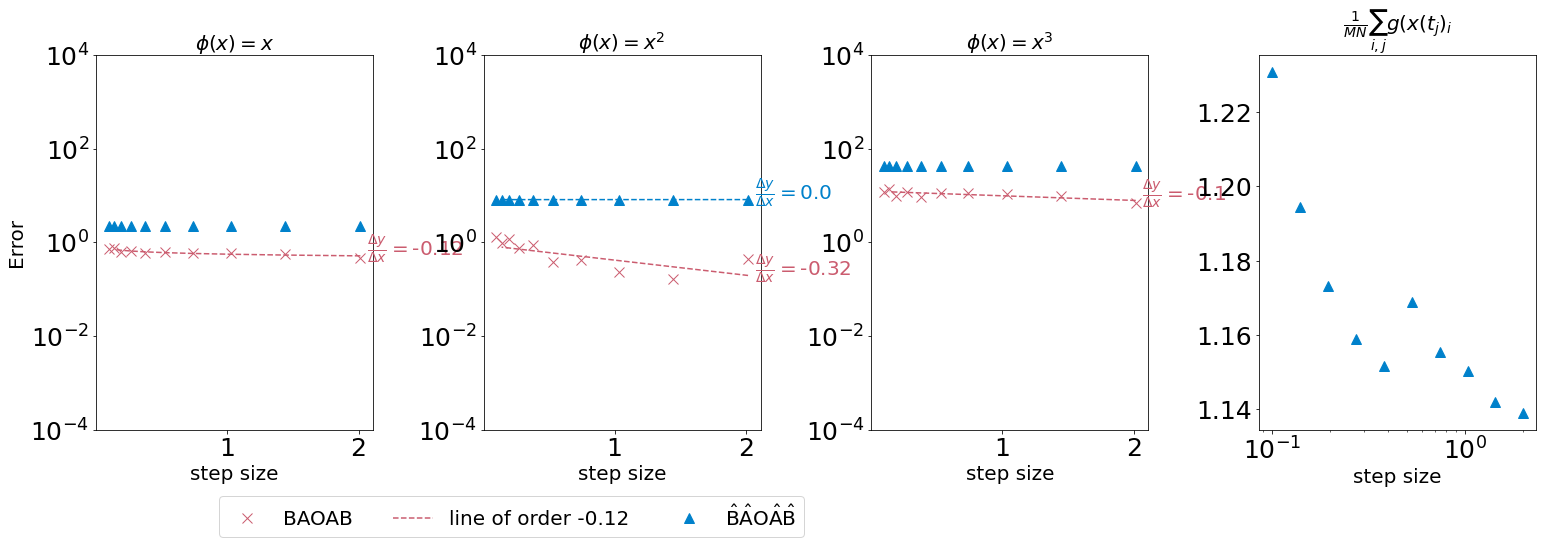

In [30]:
# from settings_and_potential_eddie import *

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/underdamped/spring_validate/v2/"
mksize=10
# 8# dtlist = np.array([np.exp(-4.5),np.exp(-4.21),np.exp(-3.93),np.exp(-3.64),np.exp(-3.36),np.exp(-3.07),np.exp(-2.79),np.exp(-2.5),np.exp(-2.21),np.exp(-1.93),np.exp(-1.64),np.exp(-1.36),np.exp(-1.07), np.exp(-0.79), np.exp(-0.5)])
dtlist=np.linspace(0.15,0.37)
# dtlist=np.array([0.15      , 0.166, 0.183, 0.203, 0.224,
#        0.248, 0.274, 0.303, 0.335, 0.37])
dtlist=np.round(np.linspace(0.01,1.5,10),4)
dtlist=np.round(np.linspace(0.001,0.1,10),4)
dtlist=np.round(np.linspace(0.05,.7,10),4)
dtlist=np.array([2.014,1.443,1.034,0.741,0.531,0.38,0.273,0.195,0.14,0.1])

# ###########################################
# ## Interpolate the slope
# ###########################################
T=100
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

## no adaptive 
###############
lab="BAOAB"
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list=np.hstack(openCfile(path1+"noada_moment1.txt"))
mom2_list=np.hstack(openCfile(path1+"noada_moment2.txt"))
mom3_list=np.hstack(openCfile(path1+"noada_moment3.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)
print(mom1_list)

# Compute the order
# ## Add the first order line to observable x^2
lb=0
ub=9 #len(dtlist)+1
x = np.log10(dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom1_list)[lb:ub]), rcond=None)[0]
ax1.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred,label="line of order "+str(np.round(m,2)))
ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)


# ## Add the first order line to observable x^2

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom2_list)[lb:ub]), rcond=None)[0]
ax2.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred)
ax2.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)

# ## Add the first order line to observable x^3

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom3_list)[lb:ub]), rcond=None)[0]
ax3.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred)
ax3.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)

## Transformed 
###############
lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"

mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list=np.hstack(openCfile(path1+"tr_moment1.txt"))
mom2_list=np.hstack(openCfile(path1+"tr_moment2.txt"))
mom3_list=np.hstack(openCfile(path1+"tr_moment3.txt"))
gvals=np.hstack(openCfile(path1+"tr_moment4.txt"))
print(mom1_list)

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)

# ## Add the first order line to observable x^2

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom2_list)[lb:ub]), rcond=None)[0]
ax2.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myblue)
ax2.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myblue,rotation=0.,fontsize=font_size)

ax1.set_ylim([10**(-4),10**4]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**4]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**4]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size,ncol=4,loc="upper center",bbox_to_anchor=(1.5, -0.15))

## Look at the results obtained on eddie

In [63]:
## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################

a=4
b=0.1
x0=0.5
c=0.1
tau=1.

def U(x):
    res = (a**1.5*b**0.5*x0*np.arctan((a/b)**0.5*(x-x0))+(a*b*(a*x0*(x-x0)-b))/(a*(x-x0)**2+b)+c*(x-x0)**2+2*c*(x-x0)*x0)*0.5
    return res

range_int=[-10,10]
r0=range_int[0]
r1=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), r0,r1)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q), r0,r1)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, r0,r1)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, r0,r1)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, r0,r1)[0],16)/norm

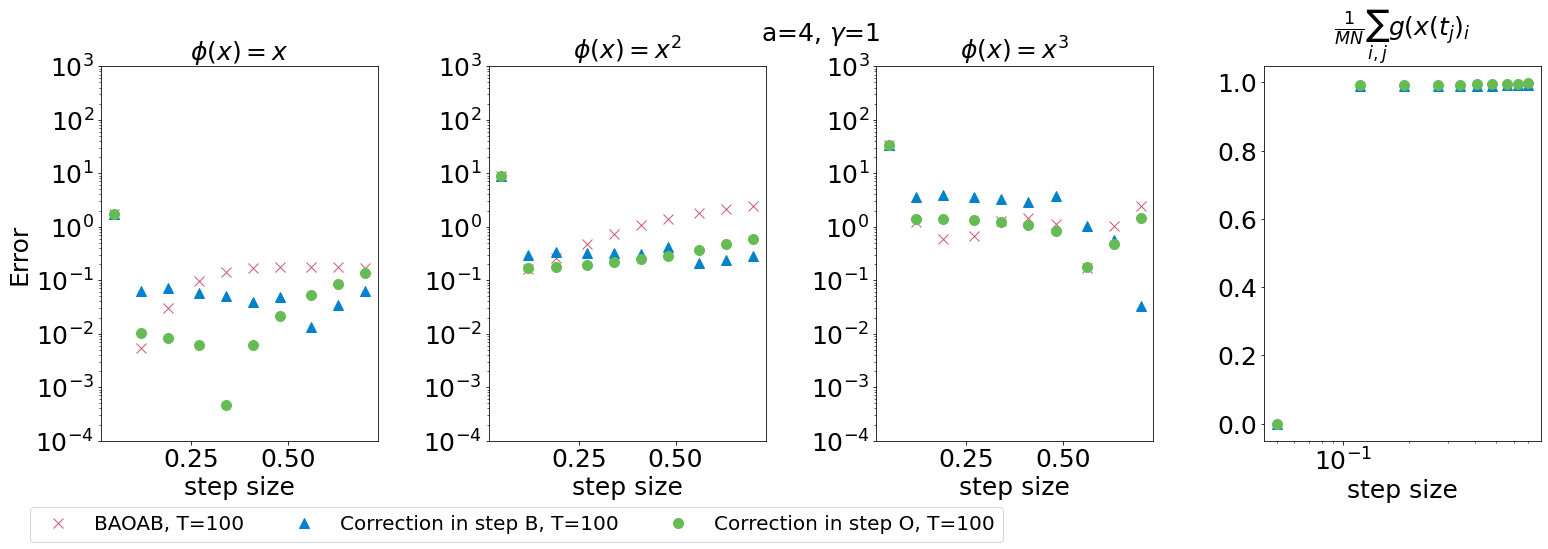

In [37]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/spring_a4_gamma1/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/15012024/spring_a4_gamma1/"

mksize=10
dtlist=np.array([0.7,0.63,0.56,0.48,0.41,0.34,0.27,0.19,0.12,0.050])

# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("a=4, $\\gamma$=1",fontsize=font_size)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
l_dt=3
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment1.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment2.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment3.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment1.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment2.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment3.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



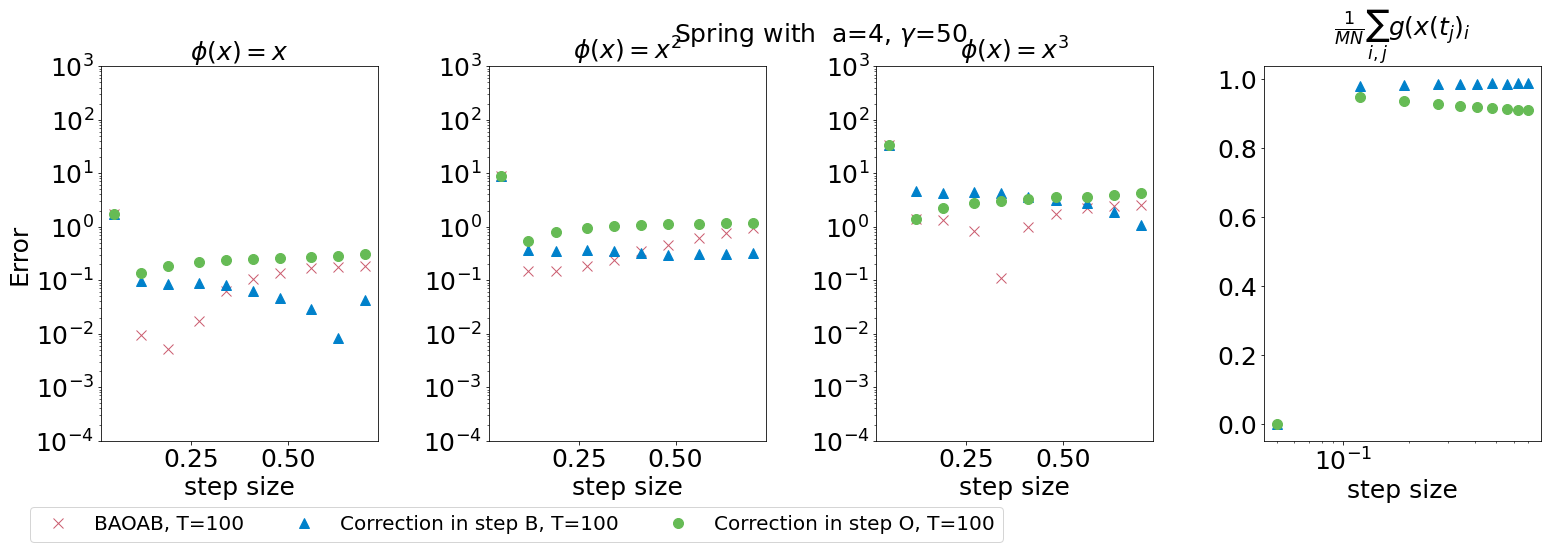

In [64]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/spring_a4_gamma50/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/15012024/spring_a4_gamma50/"

mksize=10
dtlist=np.array([0.7,0.63,0.56,0.48,0.41,0.34,0.27,0.19,0.12,0.050])

# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Spring with  a=4, $\\gamma$=50",fontsize=font_size)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
l_dt=5
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment1.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment2.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment3.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment1.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment2.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment3.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))


# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))


mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



In [60]:
## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################

a=15
b=0.1
x0=0.5
c=0.1
tau=1.

def U(x):
    res = (a**1.5*b**0.5*x0*np.arctan((a/b)**0.5*(x-x0))+(a*b*(a*x0*(x-x0)-b))/(a*(x-x0)**2+b)+c*(x-x0)**2+2*c*(x-x0)*x0)*0.5
    return res

range_int=[-10,10]
r0=range_int[0]
r1=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), r0,r1)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q), r0,r1)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, r0,r1)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, r0,r1)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, r0,r1)[0],16)/norm

[-2.16495914 -2.09303347 -2.14521404 -2.28378914 -2.3410465  -2.34026508
 -2.3468254  -2.3402727  -2.34544951 -2.339214  ]


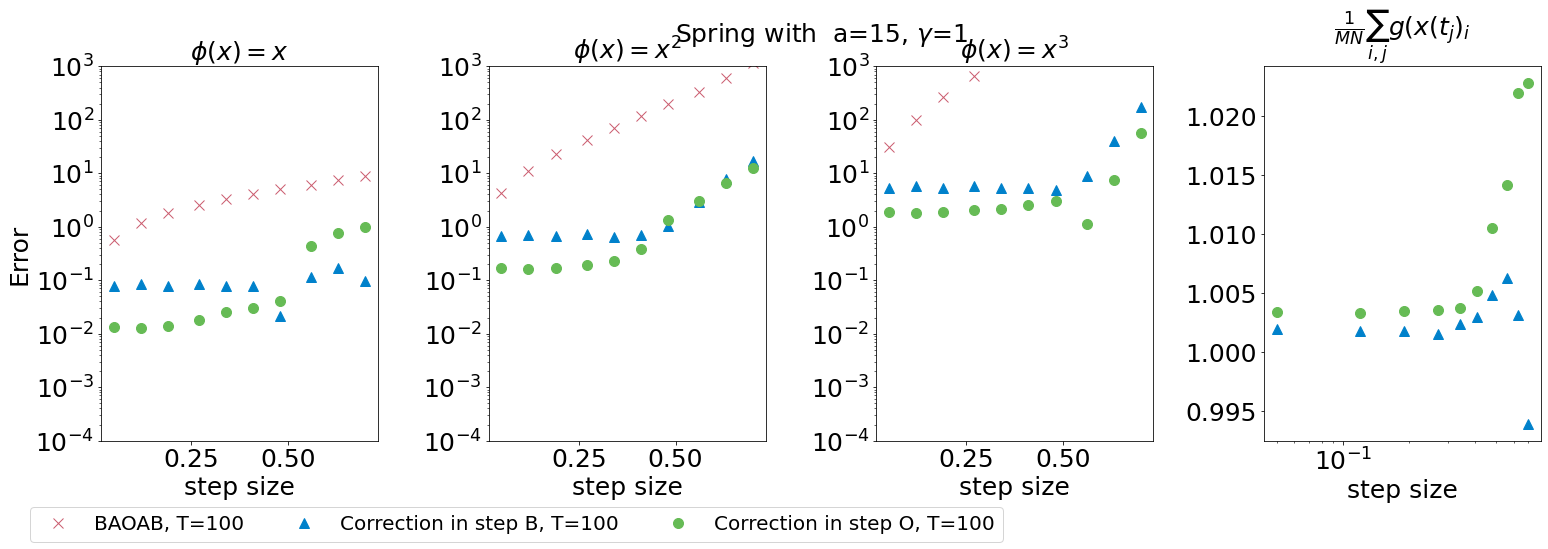

In [62]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/spring_a15_gamma1/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/15012024/spring_a15_gamma1/"

mksize=10
dtlist=np.array([0.7,0.63,0.56,0.48,0.41,0.34,0.27,0.19,0.12,0.050])

# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Spring with  a=15, $\\gamma$=1",fontsize=font_size)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))


l_dt=6
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment1.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment2.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment3.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment1.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment2.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment3.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))


# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))
print(mom1_list)
mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))



mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



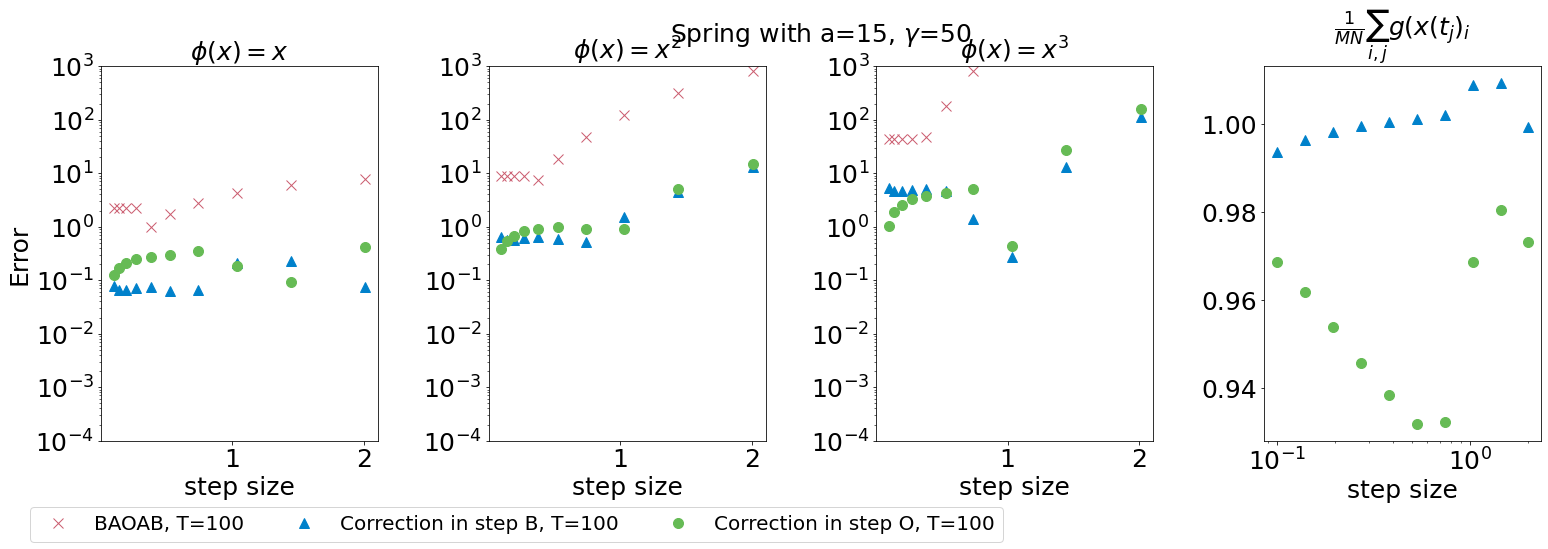

In [44]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/spring_a15_gamma50/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/15012024/spring_a15_gamma50/"

mksize=10
dtlist=np.array([2.01,1.443,1.034,0.741,0.531,0.38,0.273,0.195,0.14, 0.1])

# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("Spring with a=15, $\\gamma$=50",fontsize=font_size)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list=np.hstack(openCfile(path1+"noada_moment1.txt"))
mom2_list=np.hstack(openCfile(path1+"noada_moment2.txt"))
mom3_list=np.hstack(openCfile(path1+"noada_moment3.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))

mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**3]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



# Ben's potential

In [66]:
d=5
r=0.05
m1=0.9
M1=1/1.
def U(x):
    res = x**4*0.25+np.sin(1+d*x)
    return res

## When no access to the true moment
# ###########################################
# ## Range of integration + path to save figure
#############################################


range_int=[-10,10]
r0=range_int[0]
r1=range_int[1]
norm=np.round(integrate.quad(lambda q: np.exp(-U(q)/tau), r0,r1)[0],16)
true_mom_1 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q), r0,r1)[0],16)/norm
true_mom_2 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q, r0,r1)[0],16)/norm
true_mom_3 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*(q)**3, r0,r1)[0],16)/norm
true_mom_4 = np.round(integrate.quad(lambda q: np.exp(-U(q)/tau)*q*q*q*q, r0,r1)[0],16)/norm

line of order 4.42
line of order 0.99
line of order 5.38


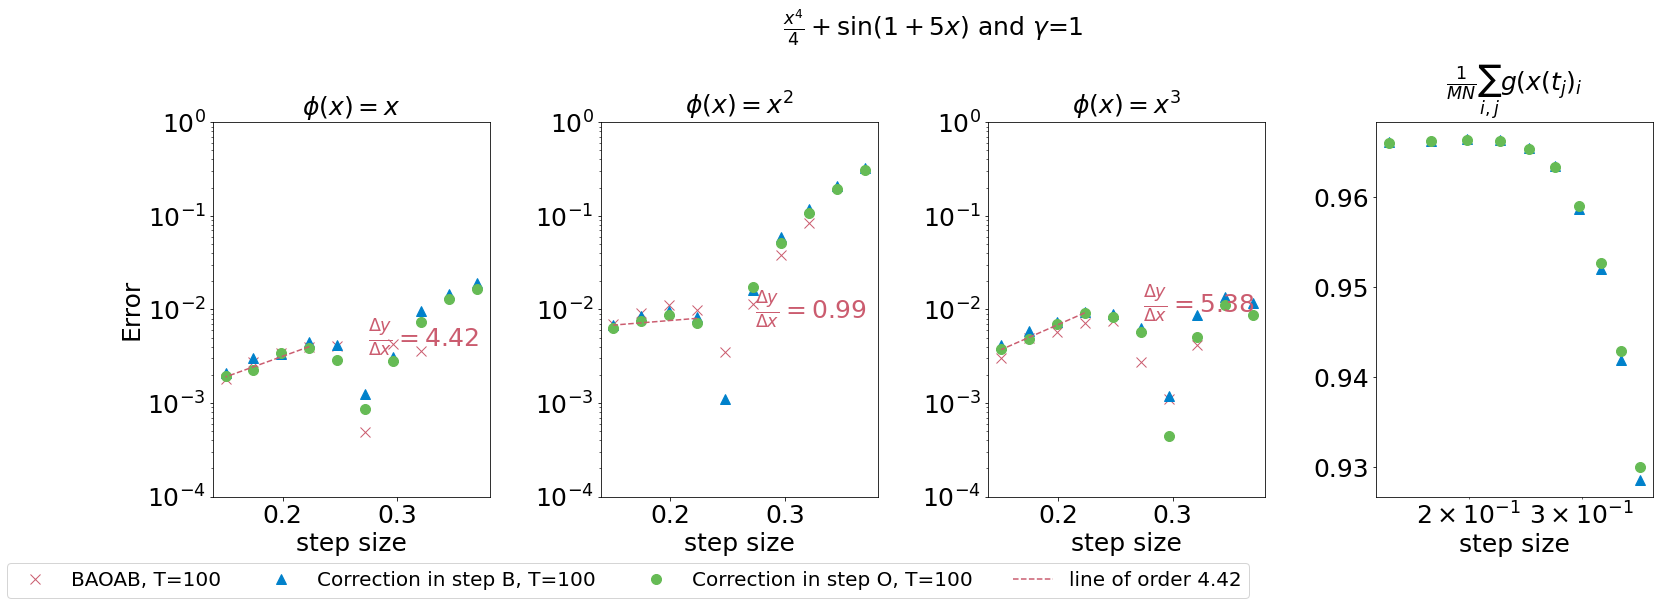

In [67]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/pot_test_gamma1/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/09012024/pot_test_gamma1/"

mksize=10
dtlist=np.array([0.37,0.3456,0.3211,0.2967,0.2722,0.2478,0.2233,0.1989,0.1744,0.15])
# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("$\\frac{x^4}{4}+\sin(1+5x)$ and $\\gamma$=1",fontsize=font_size,y=1.1)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

l_dt=4
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment1.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment2.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment3.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment1.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment2.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment3.txt"))


mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

l_dt=4
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))


mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))


l_dt=4
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))


mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)


## Transformed correction in O 
################################



# Compute the order
# ## Add the first order line to observable x^2
lb=6
ub=10 #len(dtlist)+1
x =dtlist[lb:ub]
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom1_list)[lb:ub]), rcond=None)[0]
ax1.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred,label="line of order "+str(np.round(m,2)))
ax1.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)
print("line of order "+str(np.round(m,2)))

# # ## Add the first order line to observable x^2

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom2_list)[lb:ub]), rcond=None)[0]
ax2.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred)
ax2.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)
print("line of order "+str(np.round(m,2)))

# # ## Add the first order line to observable x^3

x = (dtlist[lb:ub])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, np.log10((mom3_list)[lb:ub]), rcond=None)[0]
ax3.semilogy(dtlist[lb:ub], 10**(m*x + c),"--",color=myred)
ax3.text(dtlist[lb:ub][0]+.051,10**(m*x + c)[0]-0.00005,"$\\frac{\\Delta y}{\\Delta x}=$"+str(round(m,2)),color=myred,rotation=0.,fontsize=font_size)
print("line of order "+str(np.round(m,2)))

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**-0]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**-0]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**-0]) #change to -7.5 for a=2.5



#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



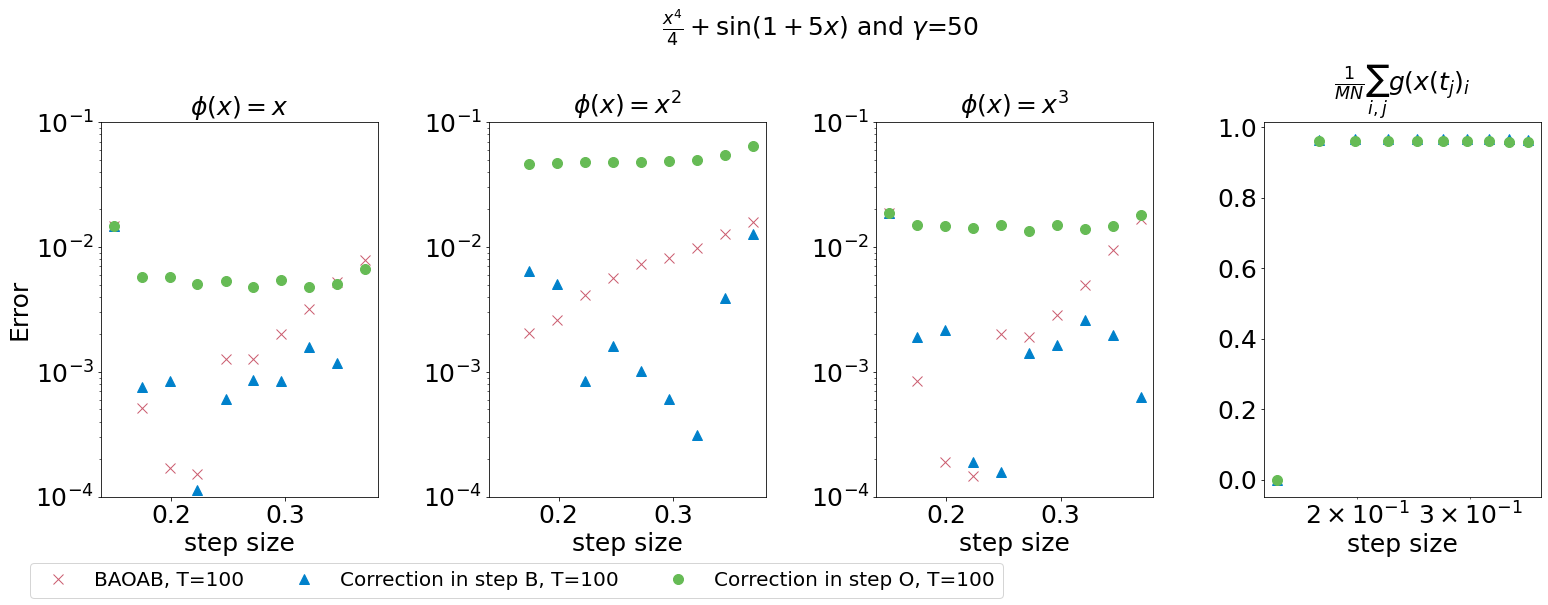

In [54]:

# ###########################################
# ## Set up the path
# ###########################################
# os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie")
path1="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/08012024/pot_test_gamma50/"
path2="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/eddie/15012024/pot_test_gamma50/"

mksize=10
dtlist=np.array([0.37,0.3456,0.3211,0.2967,0.2722,0.2478,0.2233,0.1989,0.1744,0.15])
# ###########################################
# ## Interpolate the slope
# ###########################################
T=1000
xm= (dtlist)

# ###########################################
# ## Compute the log moments
# ###########################################
fig, (ax1,ax2,ax3,ax4)= plt.subplots(1,4,figsize=(25,8))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.25, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle("$\\frac{x^4}{4}+\sin(1+5x)$ and $\\gamma$=50",fontsize=font_size,y=1.1)
T=100
## no adaptive 
###############
lab="BAOAB, T="+str(T)
mom1_list,mom2_list,mom3_list=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

l_dt=4
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment1.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment2.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"noada_moment3.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"noada_moment4.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment1.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment2.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"noada_moment3.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"noada_moment4.txt"))



mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)

#Plot moments
ax1.semilogy(xm,(mom1_list),"x",markersize=mksize,color=myred,label=lab)
ax2.semilogy(xm,(mom2_list),"x",markersize=mksize,color=myred,label=lab)
ax3.semilogy(xm,(mom3_list),"x",markersize=mksize,color=myred,label=lab)



## Transformed correction in B 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step B, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

l_dt=4
# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1B.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2B.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3B.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4B.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1B.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2B.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3B.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4B.txt"))


mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"^",markersize=mksize,color=myblue,label=lab)
ax2.semilogy(xm,(mom2_list),"^",markersize=mksize,color=myblue,label=lab)
ax3.semilogy(xm,(mom3_list),"^",markersize=mksize,color=myblue,label=lab)
ax4.semilogx(xm,(gvals),"^",markersize=mksize,color=myblue,label=lab)


## Transformed correction in O 
################################
# lab="$\\hat{\\rm{B}}\\hat{\\rm{A}}\\rm{O}\\hat{\\rm{A}}\\hat{\\rm{B}}$"
lab = "Correction in step O, T="+str(T)
mom1_list,mom2_list,mom3_list,gvals=np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist)),np.zeros(len(dtlist))

# Upload moments
mom1_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment1O.txt"))[0:l_dt]
mom2_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment2O.txt"))[0:l_dt]
mom3_list[0:l_dt]=np.hstack(openCfile(path1+"tr_moment3O.txt"))[0:l_dt]
gvals[0:l_dt]=np.hstack(openCfile(path1+"tr_moment4O.txt"))[0:l_dt]

# Upload moments
mom1_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment1O.txt"))
mom2_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment2O.txt"))
mom3_list[l_dt:10]=np.hstack(openCfile(path2+"tr_moment3O.txt"))
gvals[l_dt:10]=np.hstack(openCfile(path2+"tr_moment4O.txt"))



mom1_list=np.abs(mom1_list-true_mom_1)
mom2_list=np.abs(mom2_list-true_mom_2)
mom3_list=np.abs(mom3_list-true_mom_3)
# mom4_list=np.abs(mom4_list-true_mom_4)

ax1.semilogy(xm,(mom1_list),"o",markersize=mksize,color=mygreen,label=lab)
ax2.semilogy(xm,(mom2_list),"o",markersize=mksize,color=mygreen,label=lab)
ax3.semilogy(xm,(mom3_list),"o",markersize=mksize,color=mygreen,label=lab)
ax4.semilogx(xm,(gvals),"o",markersize=mksize,color=mygreen,label=lab)

########################################################
## Presentation of the plots ###########################
########################################################
ax1.set_ylim([10**(-4),10**-1]) #change to -7.5 for a=2.5
ax2.set_ylim([10**(-4),10**-1]) #change to -7.5 for a=2.5
ax3.set_ylim([10**(-4),10**-1]) #change to -7.5 for a=2.5


#label of y axis 
ax1.set_title("$\\phi(x)=x$",fontsize=font_size)
ax2.set_title("$\\phi(x)=x^2$",fontsize=font_size)
ax3.set_title("$\\phi(x)=x^3$",fontsize=font_size)
ax4.set_title("$\\frac{1}{M N}\\sum_{i,j} g(x(t_j)_i$",fontsize=font_size)

# label of y axis
ax1.set_ylabel("Error",fontsize=font_size)
# ax2.set_ylabel("Error",fontsize=font_size)
# ax3.set_ylabel("Error",fontsize=font_size)
# ax4.set_ylabel("$y$",fontsize=font_size)

# ax4.set_ylabel("$\\log_{\\rm{e}}(x)$",fontsize=font_size)


# label of x axis
ax1.set_xlabel("step size",fontsize=font_size)
ax2.set_xlabel("step size",fontsize=font_size)
ax3.set_xlabel("step size",fontsize=font_size)
ax4.set_xlabel("step size",fontsize=font_size)

ax1.legend(fontsize=font_size*0.8,ncol=6,loc="upper center",bbox_to_anchor=(1.5, -0.15))



In [ ]:
path="/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/data/C/data_overdamped_dw_fewtraj"

fig,((axs))= plt.subplots(numsam,2,figsize=(25,20))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
nbins=100
range_bins=[-3.,3.]
font_size=20
numsam=5
for i in range(numsam):
    filename= "/vec_noada"+str(i)+".txt"
    x_noada=np.hstack(openCfile(path+filename))
    filename= "/vec_tr"+str(i)+".txt"
    x_tr=np.hstack(openCfile(path+filename))

    # vec g 
    filename= "/vec_g"+str(i)+".txt"
    gvals=np.hstack(openCfile(path+filename))
  

    ## dont take the last value 
    # q_tr=q_tr[0:-1]
    # q_noada=q_noada[0:-1]
    # gvals=gvals[0:-1]
    numruns=len(x_tr)
    t=np.linspace(0,numruns*dt+dt,numruns)


    # Q
    ###6
    axs[i,0].plot(t,x_noada,linewidth=lw,alpha=0.9,label='Overdamped SDE',color=myred)
    axs[i,0].plot(t,x_tr,linewidth=lw,alpha=0.5,label='Transformed\noverdamped SDE',color=myblue)
    axs[i,0].set_ylim(-2.5,2.5)
    axs[i,0].set_ylabel("$y(t_n)$", fontsize=font_size*1.3)
    axs[i,0].set_xlabel("Number of steps", fontsize=font_size*1.3)
    # ylabval=[-2.,-1.,0.,1.,2.]
    # labels = ["-2.","-1.","0.","1.","2."]
    # axs[i,0].set_yticks(ylabval, labels,fontsize=font_size*1.5)
   


    ############
    ## Values of g vals ## 
    ############
    range_bins_g=[0,2.5+0.1]
    # print()
    # histogram_g,bins = np.histogram(gvals,bins=nbins,range=range_bins_g, density=True)
    # midx_noada = (bins[0:-1]+bins[1:])/2
    # mean_g=round(np.mean(g),2)
    # print(mean_g)
    axs[i,1].plot(t,gvals,linewidth=lw,label='Values taken by\nthe rescaling function',color=mygrey)
    axs[i,1].axhline(np.mean(gvals),linewidth=lw,label='Mean value of\nthe rescaling function',color=myyellow)
    print(np.mean(gvals))
    axs[i,1].set_ylim(0.,2.3)
    axs[i,1].set_ylabel("$g(y(t_n))$", fontsize=font_size*1.3)
    axs[i,1].set_xlabel("Number of steps", fontsize=font_size*1.3)

    ylabval=[0.5,1.,1.5,2.]
    labels = ["0.5","1.0","1.5","2.0"]
    axs[i,1].set_yticks(ylabval, labels,fontsize=font_size*1.5)
   

    # axs[i,2].legend(fontsize=font_size, loc="upper center")

axs[0,0].legend(fontsize=font_size,loc="upper center",ncol=3,bbox_to_anchor=(0.5, 1.52))
axs[0,1].legend(fontsize=font_size,loc="upper center",ncol=3,bbox_to_anchor=(0.5, 1.52))

os.chdir("/home/s2133976/OneDrive/ExtendedProject/Code/Stepupyourgame/Stepupyourgame/C++/overdamped/visualisation")
fig.savefig("figures/chains_anisotropic_model.eps",dpi=1000)
fig.savefig("figures/chains_anisotropic_model.pdf")